# Stereo Camera Calibration

Falk Mielke, FunMorph, Universiteit Antwerpen


You can download this notebook [here](user://notebooks/Camera_Calibration.ipynb?download&target=_blank).

---


For a student project, I have been playing around with stereo camera calibration. 
We have a set of cameras.
The challenge is **to obtain 3D kinematics by combining data from multiple views** (i.e. simultaneously captured images from different perspectives). 


Below, I document my attempts to relate the image space of the cameras (i.e. what is seen on each frame) to object space (i.e. the true 3D position of something). 



Here is the usual extensive set of libraries I use below.

In [1]:
import numpy as NP # numeric operations
import pandas as PD # data organization

import cv2 as CV # open computer vision, i.e. image manipulation library

import sympy as SYM # symbolic python
import sympy.physics.mechanics as MECH # symbolic mechanics


import matplotlib as MP # plotting
import matplotlib.pyplot as MPP # plotting
from mpl_toolkits import mplot3d # 3D plots


# equal aspect for matplotlib 3D plots
# from https://stackoverflow.com/a/19248731
def AxisEqual3D(ax):
    extents = NP.array([getattr(ax, f'get_{dim}lim')() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = NP.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, f'set_{dim}lim')(ctr - r, ctr + r)

# Ingredients

We have a set of consumer level GoPro "Hero 5" in the lab, three of which were attached to a rack of metal tubes.
All were set to narrow field of view (to minimize fisheye lens distortion). 
Videos of resolution $1280\times 720$ @ 240 fps were triggered with a remote control. 

The same video settings were used to film a regular grid for undistortion (procedure as described [here](../undistortion?target=_blank)), which was applied to all the material used below.

The remote control sync was not accurate, which I found out only after calibration. I will use an extra audio clue in the future.

The setup is lightweight, mobile, and thus suited for field work.

# Calibration Data

As a test calibration object, I grabbed a monitor box that was lying around in the office.

<img src="images/cam1.png" width=400>


To get true 3D points, I prepared a 3D model of the box by photogrammetry. 
Then, I used the "PickPoints" function in [`meshlab`](https://www.meshlab.net?target=_blank) to get relative positions of the corner points and two extra landmarks on the box.

Taking simultaneous photos from the fixed cameras, I could also retrieve image points. 
Prior to calibration, those images were contrast enhanced and undistorted. 
All relevant images have to be prepared with the same procedure.


In [2]:
data = PD.read_csv('cam_calibration_data.csv', sep = ';').set_index('pt', inplace = False)
data

x         y         z         u_1         v_1          u_2  \
pt                                                                      
0  -0.235521  0.308646  0.101321  321.426491  111.782226   786.011187   
1  -0.000698  0.311595  0.094717  180.229182  143.665489   710.098655   
2  -0.004713 -0.328370  0.089341  365.455760  315.986937  1073.719682   
3  -0.236395 -0.329500  0.092263  522.594701  272.716794  1129.894956   
4   0.005713  0.315304 -0.349343  203.762067  394.935970   685.047519   
5   0.001885 -0.331354 -0.345600  379.879141  596.104179  1025.894787   
6  -0.229327 -0.330225 -0.348522  524.872077  546.001908  1082.829186   
7   0.000000  0.000000  0.000000  266.010343  279.548921   868.755846   
8  -0.132960  0.025250  0.097379  338.886374  191.490384   899.120859   

           v_2         u_4         v_4  
pt                                      
0   252.220410  664.551136   65.475581  
1   287.899300  537.777207   91.285842  
2   405.563724  814.857949  221.855397  
3   363.811832  946.186629  186.935632  
4   527.023775  535.499831  356.979704  
5   662.148082  792.084189  524.746399  
6   606.731934  915.062491  479.198880  
7   397.213346  656.200757  211.227643  
8   313.709561  720.726409  125.446482

Note that object points are in meters, and should have a meaningful origin.

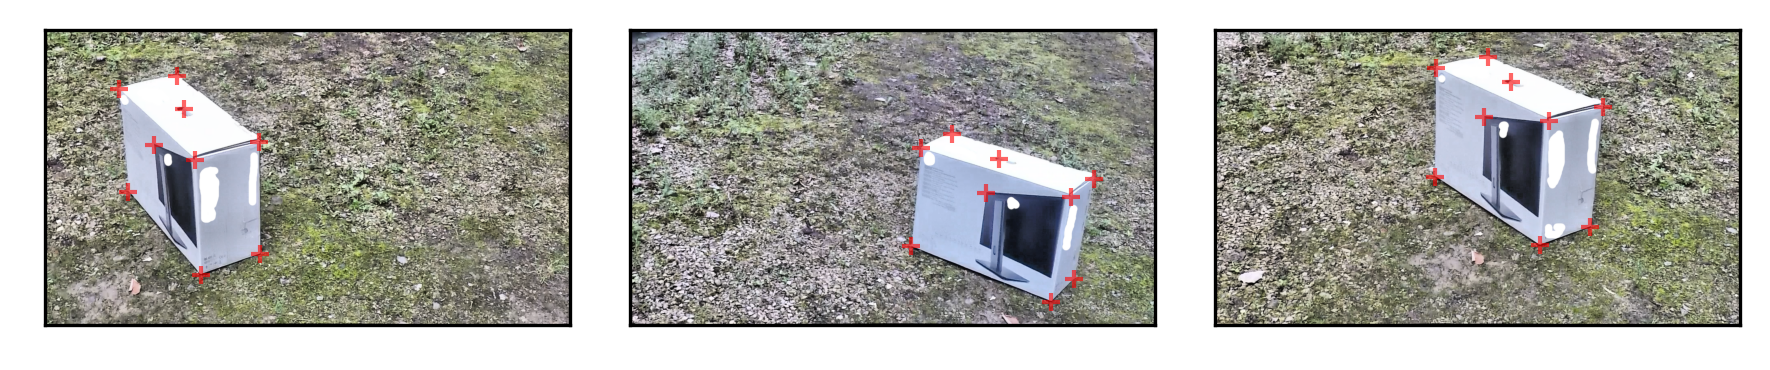

In [3]:
cams = [1,2,4]
images = {cam: CV.imread(f'images/cam{cam}.png', 1) for cam in cams}

# drawing its lines on left image
fig = MPP.figure(dpi = 300)

for nr, (cam, img) in enumerate(images.items()):
    ax = fig.add_subplot(1, len(images), nr+1, aspect = 'equal')
    ax.imshow(img[:, :, ::-1], origin = 'upper')
    
    pts = data.loc[:, [f'u_{cam}', f'v_{cam}']].values
    
    ax.scatter(pts[:, 0], pts[:, 1], s = 20 \
               , marker = '+', facecolor = 'r', edgecolor = '0' \
              , linewidth = 1, alpha = 0.6 \
              )
    
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel(nr)
    
MPP.tight_layout()
MPP.show()


Of course, the points must always be labeled in the same order. 
It would be better to use point labels as `pandas` data frame indices to make sure only matching points are associated.

In addition to the points on the images, the true 3D relation of the point is known:

In [4]:
data.loc[:, ['x', 'y', 'z']].T

pt         0         1         2         3         4         5         6    7  \
x  -0.235521 -0.000698 -0.004713 -0.236395  0.005713  0.001885 -0.229327  0.0   
y   0.308646  0.311595 -0.328370 -0.329500  0.315304 -0.331354 -0.330225  0.0   
z   0.101321  0.094717  0.089341  0.092263 -0.349343 -0.345600 -0.348522  0.0   

pt         8  
x  -0.132960  
y   0.025250  
z   0.097379

This can be used for calibration. 

# The Successful Attempt: DLT Calibration à la Argus/Kwon

My initial temptation was to go to [openCV](https://opencv.org?target=_blank). 
For several reasons, these attempts failed (see below). 

On the search for alternatives, I [stumbled upon](http://argus.web.unc.edu?target=_blank) the **argus toolbox** from Ty Hedrick's lab (Jackson et al., 2016). 
The toolbox had previously been recommended to me by a colleague, [François Druelle](https://twitter.com/DruelleFranois1).

I went through to the procedures referenced in the argus "theory" section. 
The authors implement algorithms collected in the [Motion Analysis library of Young-Hoo Kwon](http://kwon3d.com/theories.html?target=_blank). 
The **Kwon3D website** (Kwon, 2000) is a phenomenal resource for my research. 
I have already [referenced](http://www.kwon3d.com/theory/grf/cop.html?target=_blank) [the website](http://www.kwon3d.com/theory/grf/pad.html?target=_blank) in my [force plate blog posts](../fpcalculations?target=_blank). 
I have now realized that my recent quest on solving inverse dynamics could have been facitilated by [theory assembled on Kwon's archives](http://kwon3d.com/theory/jtorque/jtorque.html?target=_blank). 
And now, I also use the [section on camera calibration via DLT](http://kwon3d.com/theory/dlt/dlt.html?target=_blank) for my purpose. 


## Theory

I start here with the naked maths. 
If that is of less interest to you, feel free to skip to the "numeric application" section below.

The [website by Kwon](http://kwon3d.com/theory/dlt/dlt.html?target=_blank) excellently explains the DLT theory. 
I will repeat it here in a `sympy` framework, using the same symbols. 



In [5]:
# object space coordinates
x, y, z = SYM.symbols(f'x:z', real = True)
x0, y0, z0 = SYM.symbols(f'x_0, y_0, z_0', real = True)

# image space coordinates
u, v = SYM.symbols(f'u, v', real = True)
u0, v0, d = SYM.symbols(f'u_0, v_0, d', real = True)

# reference frame DCM
r = SYM.symbols('r_{1:4}{1:4}', real = True)
T_io = SYM.Matrix([r[:3],r[3:6],r[6:]]).T

# colinearity
c = SYM.symbols(f'c', real = True)


We require two reference frames. One is the object space, the other is the image plane (extended to 3D towards the focal point).

In [6]:
# object space
object_space = MECH.ReferenceFrame('O')

# image plane
image_plane = MECH.ReferenceFrame('I')
image_plane.orient(object_space, 'DCM', T_io)

# static
image_plane.set_ang_vel(object_space, 0)
image_plane.set_ang_acc(object_space, 0)

# transform between spaces
object_to_image = SYM.simplify(image_plane.dcm(object_space)) # frame_to.dcm(frame_from)
image_to_object = SYM.simplify(object_space.dcm(image_plane))

SYM.pprint(object_to_image)

⎡r_{1}{1}  r_{1}{2}  r_{1}{3}⎤
⎢                            ⎥
⎢r_{2}{1}  r_{2}{2}  r_{2}{3}⎥
⎢                            ⎥
⎣r_{3}{1}  r_{3}{2}  r_{3}{3}⎦


There are several points that can be located in either of the two reference frames. 
Most notably, the "projection center" (i.e. focal point) of the image can be located in both frames and connects the two.

In [7]:
### define the origins
# ... of the object space
origin = MECH.Point('Ω')

# of the image plane
origin_image = MECH.Point('ρ')

### points in the world
# object point in the world
obj_point = MECH.Point('ο')
obj_point.set_pos(origin, x * object_space.x + y * object_space.y + z * object_space.z)

### points in both worlds
# projection center: where all object point/projections meet
proj_center = MECH.Point('ν')
proj_center.set_pos(origin_image, u0 * image_plane.x + v0 * image_plane.y + d * image_plane.z)
proj_center.set_pos(origin, x0 * object_space.x + y0 * object_space.y + z0 * object_space.z)

### points in the image
# principal point (center of image plane; perpendicular axis through image plane and projection center)
principal_point = MECH.Point('π')
principal_point.set_pos(origin_image, u0 * image_plane.x + v0 * image_plane.y + 0 * image_plane.z)

# projection of the object point to the image plane
img_point = MECH.Point('ι')
img_point.set_pos(origin_image, u * image_plane.x + v * image_plane.y + 0 * image_plane.z)


### static: no movement of no point
for point in [origin, origin_image, obj_point, proj_center, principal_point, img_point]: 
    point.set_vel(object_space, 0)
    point.set_acc(object_space, 0)
    point.set_vel(image_plane, 0)
    point.set_acc(image_plane, 0)


Take any vector which goes from the projection center to a true 3D point. 
Any such vector intersects the image plane at an image point. 
The vectors to the true point and to the plane are colinear, i.e. related by scalar multiplication.

This is the **collinearity condition**. 
It gives linear equations that relate the two spaces.

In [8]:
### vectors
A_o = obj_point.pos_from(proj_center).express(object_space)
B_i = img_point.pos_from(proj_center).express(image_plane)

A_i = A_o.express(image_plane)


equations = { coord: c*A_i.dot(coord) - B_i.dot(coord) \
              for coord in [image_plane.x, image_plane.y, image_plane.z] \
            }

equations

{I.x: c*(r_{1}{1}*(x - x_0) + r_{1}{2}*(y - y_0) + r_{1}{3}*(z - z_0)) - u + u_0,
 I.y: c*(r_{2}{1}*(x - x_0) + r_{2}{2}*(y - y_0) + r_{2}{3}*(z - z_0)) - v + v_0,
 I.z: c*(r_{3}{1}*(x - x_0) + r_{3}{2}*(y - y_0) + r_{3}{3}*(z - z_0)) + d}

Some values need to be substituted in, (i) to reduce dimensionality, (ii) to correct for an arbitrary scaling factor.

In [9]:
c_substitute = {c: SYM.solve(equations[image_plane.z], c)[0]}

λ_u, λ_v = SYM.symbols(f'λ_u, λ_v', real = True)
uv_substitutes = { \
                   (u-u0): λ_u * (u-u0) \
                 , (v-v0): λ_v * (v-v0) \
                 }

equations = { coord: equations[coord].subs(c_substitute).subs(uv_substitutes) \
              for coord in [image_plane.x, image_plane.y] \
            }
equations

{I.x: -d*(r_{1}{1}*(x - x_0) + r_{1}{2}*(y - y_0) + r_{1}{3}*(z - z_0))/(r_{3}{1}*x - r_{3}{1}*x_0 + r_{3}{2}*y - r_{3}{2}*y_0 + r_{3}{3}*z - r_{3}{3}*z_0) - λ_u*(u - u_0),
 I.y: -d*(r_{2}{1}*(x - x_0) + r_{2}{2}*(y - y_0) + r_{2}{3}*(z - z_0))/(r_{3}{1}*x - r_{3}{1}*x_0 + r_{3}{2}*y - r_{3}{2}*y_0 + r_{3}{3}*z - r_{3}{3}*z_0) - λ_v*(v - v_0)}

Finally, the resulting equations can be solved to get formulas for `u` and `v` (image coordinates) as a function of `x`, `y` and `z` (object coordinates).

In [10]:
u_eqn = SYM.Eq( u, SYM.simplify(SYM.solve(equations[image_plane.x], u)[0]).factor(x, y, z) )
v_eqn = SYM.Eq( v, SYM.simplify(SYM.solve(equations[image_plane.y], v)[0]).factor(x, y, z) )
solutions = [u_eqn, v_eqn]
for sol in solutions:
    SYM.pprint(sol)

    -(-d⋅r_{1}{1}⋅x₀ - d⋅r_{1}{2}⋅y₀ - d⋅r_{1}{3}⋅z₀ + r_{3}{1}⋅u₀⋅x₀⋅λᵤ + r_{
u = ──────────────────────────────────────────────────────────────────────────
                                                                    λᵤ⋅(r_{3}{

3}{2}⋅u₀⋅y₀⋅λᵤ + r_{3}{3}⋅u₀⋅z₀⋅λᵤ + x⋅(d⋅r_{1}{1} - r_{3}{1}⋅u₀⋅λᵤ) + y⋅(d⋅r_
──────────────────────────────────────────────────────────────────────────────
1}⋅x - r_{3}{1}⋅x₀ + r_{3}{2}⋅y - r_{3}{2}⋅y₀ + r_{3}{3}⋅z - r_{3}{3}⋅z₀)     

{1}{2} - r_{3}{2}⋅u₀⋅λᵤ) + z⋅(d⋅r_{1}{3} - r_{3}{3}⋅u₀⋅λᵤ)) 
────────────────────────────────────────────────────────────
                                                            
    -(-d⋅r_{2}{1}⋅x₀ - d⋅r_{2}{2}⋅y₀ - d⋅r_{2}{3}⋅z₀ + r_{3}{1}⋅v₀⋅x₀⋅λᵥ + r_{
v = ──────────────────────────────────────────────────────────────────────────
                                                                    λᵥ⋅(r_{3}{

3}{2}⋅v₀⋅y₀⋅λᵥ + r_{3}{3}⋅v₀⋅z₀⋅λᵥ + x⋅(d⋅r_{2}{1} - r_{3}{1}⋅v₀⋅λᵥ) + y⋅(d⋅r_
────────────────────────

You can convince yourself that this result is identical to the common DLT expression.

`Sympy` can perform what is called *common subexpression elimination*:

In [11]:
cse_replacements, dlt_terms = SYM.cse(solutions, symbols = SYM.utilities.iterables.numbered_symbols('L')) 
SYM.pprint(dlt_terms)

⎡    -L₃⋅(L₀⋅L₇ + L₁⋅L₇ + L₂⋅L₇ - L₄⋅x₀ - L₅⋅y₀ - L₆⋅z₀ + x⋅(L₄ - L₇⋅r_{3}{1})
⎢u = ─────────────────────────────────────────────────────────────────────────
⎣                                                                λᵤ           

 + y⋅(L₅ - L₇⋅r_{3}{2}) + z⋅(L₆ - L₇⋅r_{3}{3}))       -L₃⋅(L₀⋅L₁₁ + L₁⋅L₁₁ - L
────────────────────────────────────────────────, v = ────────────────────────
                                                                              

₁₀⋅z₀ + L₁₁⋅L₂ - L₈⋅x₀ - L₉⋅y₀ + x⋅(-L₁₁⋅r_{3}{1} + L₈) + y⋅(-L₁₁⋅r_{3}{2} + L
──────────────────────────────────────────────────────────────────────────────
                                         λᵥ                                   

₉) + z⋅(L₁₀ - L₁₁⋅r_{3}{3})) ⎤
─────────────────────────────⎥
                             ⎦


However, this yields different parameters than the "guided" DLT parameters presented by Kwon. 


The significant achievement of such DLT parameters is that one can build a system of linear equations to solve for the $L_i$'s.

## Numeric Application

Multiplying by the RHS denominator, moving mixed terms to the right side and thereby isolating `u, v` results in such a **system of linear equations**. 
A system of linear equations can be solved by linear algebra. 
And if thinking of *linear algebra* raises your neck hair, rest assured that `python` will do the work for you. 

Argus (Jackson et al., 2016) uses [`numpy.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html?target=_blank) for this. 
The function requires two matrices $A$ and $B$, for which we get $L$ (the DLT parameters) from $A L = B$. 
To solve the systems, $N$ points have to be known in both image and object space.

$A$ is the **coefficient matrix**, shape $(2N \times 11)$. The number $11$ comes from $11$ $L$ coefficients in the problem. 

$ A = \begin{array}{c | ccccccccccc}
i & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 \\ 
\hline 2k & x_k & y_k & z_k & 1 & 0 & 0 & 0 & 0 & -u_k x_k & -u_k y_k & -u_k z_k \\ 
2k+1 & 0 & 0 & 0 & 0 & x_k & y_k & z_k & 1 & -v_k x_k & -v_k y_k & -v_k z_k 
\end{array} \quad\quad \forall k \in \{0, N-1\} $


And $B$ is the dependent matrix:

$ B = \begin{array}{c | c}
 &  \\ 
\hline 2k & u_k \\ 
2k+1 & v_k  
\end{array} \quad\quad \forall k \in \{0, N-1\} $

Then, computationally, $\mid\mid B - A L \mid\mid$ is minimized by the least squares method.

Sounds fun? Here is the function, adapted from the [argus code](https://github.com/kilmoretrout/argus_gui.git).

In [12]:
def SolveDLT(data, cam):
    # solve DLT for a camera 
    # from N known points
    # adapted from https://github.com/kilmoretrout/argus_gui/blob/master/argus_gui/tools.py `solve_dlt`
    # input: a data frame with [x, y, z, u_i, v_i] columns where i is the camera index
    
    # coefficient matrix
    A = NP.zeros((data.shape[0] * 2, 11))

    # dependent variable
    B = NP.zeros((data.shape[0] * 2, 1))


    # fill the matrices
    for k, row in data.iterrows():
        A[2 * k, :3] = row[['x', 'y', 'z']].values
        A[2 * k, 3] = 1
        A[2 * k, 8:] = row[['x', 'y', 'z']].values * -row[f'u_{cam}']
        A[2 * k + 1, 4:7] = row[['x', 'y', 'z']].values
        A[2 * k + 1, 7] = 1
        A[2 * k + 1, 8:] = row[['x', 'y', 'z']].values * -row[f'v_{cam}']

        B[2 * k] = row[f'u_{cam}']
        B[2 * k + 1] = row[f'v_{cam}']

    # solve system of linear equations
    L = NP.linalg.lstsq(A, B, rcond=None)[0]
    return L.ravel()

Taking our data from above, the function can yield DLT parameters for the three cameras:

In [13]:
L = {cam: SolveDLT(data, cam = cam) for cam in cams}
L

{1: array([-7.03913782e+02, -2.04857500e+02, -1.03511822e+02,  2.65781236e+02,
         1.10530429e+02, -1.96650553e+02, -6.71888993e+02,  2.79123077e+02,
        -1.88877266e-01,  2.75455293e-01, -1.71605937e-01]),
 2: array([-5.55001628e+02, -3.98060092e+02, -5.05956178e+01,  8.68303335e+02,
         6.55700125e+01, -1.17488996e+02, -6.36343639e+02,  3.96662992e+02,
        -2.90184236e-01,  1.79093742e-01, -1.44750418e-01]),
 4: array([-7.29359405e+02, -2.20829579e+02, -9.97698632e+01,  6.56184624e+02,
         8.31303936e+01, -1.49535713e+02, -7.05594977e+02,  2.11502025e+02,
        -2.37017457e-01,  2.95065936e-01, -1.74821150e-01])}

To confirm the accuracy, we can project the 3D points to the image plane and check whether points match:

In [14]:
for cam in cams:
    
    for coord in ['u', 'v']:
        data[f'{coord}_{cam}_reco'] = 0
        
    for k, row in data.iterrows():
            data.loc[k, f'u_{cam}_reco'] = (NP.dot(L[cam][:3].T, row[['x', 'y', 'z']].values) + L[cam][3]) \
                                    / (NP.dot(L[cam][-3:].T, row[['x', 'y', 'z']].values) + 1.)
            data.loc[k, f'v_{cam}_reco'] = (NP.dot(L[cam][4:7].T, row[['x', 'y', 'z']].values) + L[cam][7]) \
                                    / (NP.dot(L[cam][-3:].T, row[['x', 'y', 'z']].values) + 1.)

data.loc[:, ['x', 'y', 'z', 'u_1', 'v_1', 'u_1_reco', 'v_1_reco']]

x         y         z         u_1         v_1    u_1_reco  \
pt                                                                     
0  -0.235521  0.308646  0.101321  321.426491  111.782226  321.775150   
1  -0.000698  0.311595  0.094717  180.229182  143.665489  180.082729   
2  -0.004713 -0.328370  0.089341  365.455760  315.986937  365.453553   
3  -0.236395 -0.329500  0.092263  522.594701  272.716794  522.499640   
4   0.005713  0.315304 -0.349343  203.762067  394.935970  203.651747   
5   0.001885 -0.331354 -0.345600  379.879141  596.104179  380.403750   
6  -0.229327 -0.330225 -0.348522  524.872077  546.001908  524.553708   
7   0.000000  0.000000  0.000000  266.010343  279.548921  265.781236   
8  -0.132960  0.025250  0.097379  338.886374  191.490384  338.916072   

      v_1_reco  
pt              
0   111.785891  
1   144.087333  
2   316.329381  
3   272.692276  
4   394.920945  
5   595.960378  
6   546.239586  
7   279.123077  
8   191.099186

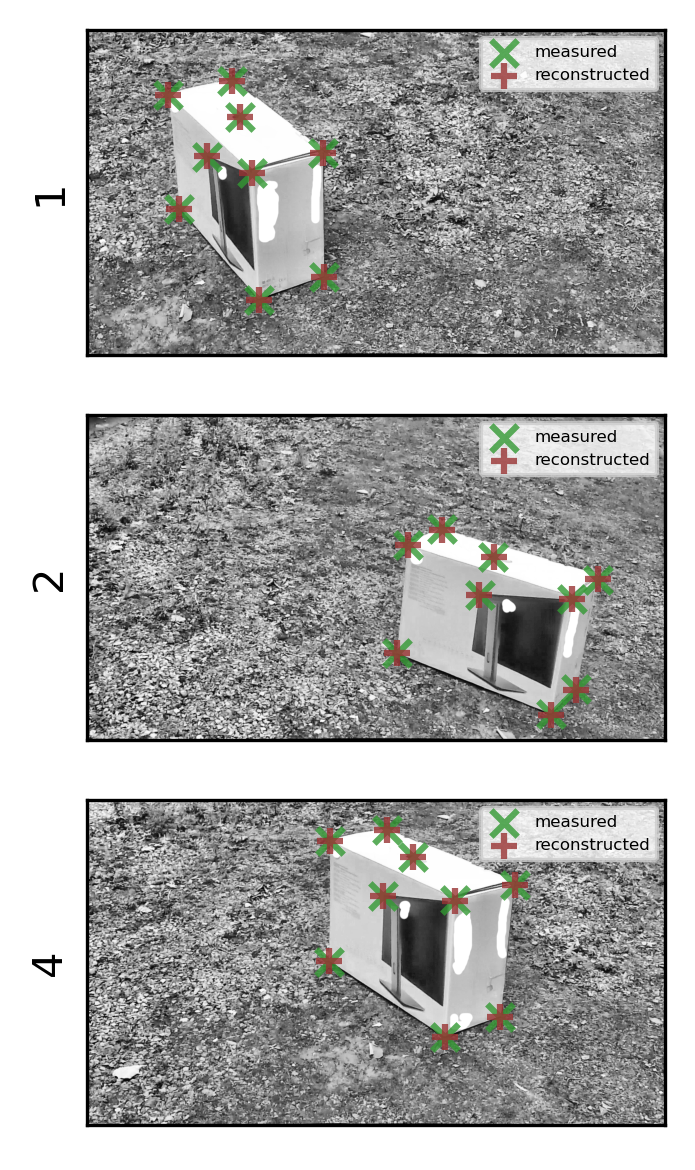

In [15]:
fig = MPP.figure(dpi = 300)

for nr, cam in enumerate(cams):
    ax = fig.add_subplot(3, 1, nr+1, aspect = 'equal')

    ax.imshow(NP.mean(images[cam][:, :], axis = 2), cmap = 'gray', origin = 'upper')
    
    ax.scatter(  data[f'u_{cam}'].values \
               , data[f'v_{cam}'].values \
               , s = 40 \
               , marker = 'x' \
               , color = (0.2, 0.6, 0.2) \
               , alpha = 0.8 \
               , label = 'measured' \
              )
    ax.scatter(  data[f'u_{cam}_reco'].values \
               , data[f'v_{cam}_reco'].values \
               , s = 40 \
               , marker = '+' \
               , color = (0.6, 0.2, 0.2) \
               , alpha = 0.8 \
               , label = 'reconstructed' \
              )

    ax.legend(loc = 'best', fontsize = 4)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(cam)
    
fig.tight_layout()
MPP.show();

This check is trivial, but it looks like a match.

We'll store the DLT parameters as a matrix.

In [16]:
# dlt: (number of cameras)x11 array of DLT coefficients
dlt = NP.stack([L[cam] for cam in cams], axis = 0)
dlt

array([[-7.03913782e+02, -2.04857500e+02, -1.03511822e+02,
         2.65781236e+02,  1.10530429e+02, -1.96650553e+02,
        -6.71888993e+02,  2.79123077e+02, -1.88877266e-01,
         2.75455293e-01, -1.71605937e-01],
       [-5.55001628e+02, -3.98060092e+02, -5.05956178e+01,
         8.68303335e+02,  6.55700125e+01, -1.17488996e+02,
        -6.36343639e+02,  3.96662992e+02, -2.90184236e-01,
         1.79093742e-01, -1.44750418e-01],
       [-7.29359405e+02, -2.20829579e+02, -9.97698632e+01,
         6.56184624e+02,  8.31303936e+01, -1.49535713e+02,
        -7.05594977e+02,  2.11502025e+02, -2.37017457e-01,
         2.95065936e-01, -1.74821150e-01]])

## 3D Point Reconstruction

When filming a calibration object, we know the true positions of points.
Afterwards, when filming a scene, the goal is to take the observed image points and get their relative position in 3D, i.e. in "world coordinates". 

The [argus code](https://github.com/kilmoretrout/argus_gui.git) (Jackson et al., 2016) also contains a function for that.

In [17]:


def UVtoXYZ(pts, dlt):
    # retrieve Object Points (3D) from multiple perspective Image Points
    # adapted from https://github.com/kilmoretrout/argus_gui/blob/master/argus_gui/tools.py `uv_to_xyz`
    #     pts: (N x 2K) array of N 2D points for K cameras
    #          can be a single point over time, or multiple points in one scene
    #     dlt: (11 x K) array of DLT parameters
    # Adjusted because data points herein are undistorted prior to calculation
    
    # initialiye empty data array
    xyzs = NP.empty((len(pts), 3))
    xyzs[:] = NP.nan
    
    # for each point 
    for i in range(len(pts)):
        uvs = list()
        # for each uv pair
        for j in range(len(pts[i]) // 2):
            # do we have a NaN pair?
            if not True in NP.isnan(pts[i, 2 * j:2 * (j + 1)]):
                # if not append the undistorted point and its camera number to the list
                uvs.append([pts[i, 2 * j:2 * (j + 1)], j])

        if len(uvs) > 1:
            # if we have at least 2 uv coordinates, setup the linear system
            A = NP.zeros((2 * len(uvs), 3))

            # assemble coefficient matrix of the linear system
            for k in range(len(uvs)):
                A[k] = NP.asarray([uvs[k][0][0] * dlt[uvs[k][1]][8] - dlt[uvs[k][1]][0],
                                   uvs[k][0][0] * dlt[uvs[k][1]][9] - dlt[uvs[k][1]][1],
                                   uvs[k][0][0] * dlt[uvs[k][1]][10] - dlt[uvs[k][1]][2]])
                A[k + 1] = NP.asarray([uvs[k][0][1] * dlt[uvs[k][1]][8] - dlt[uvs[k][1]][4],
                                       uvs[k][0][1] * dlt[uvs[k][1]][9] - dlt[uvs[k][1]][5],
                                       uvs[k][0][1] * dlt[uvs[k][1]][10] - dlt[uvs[k][1]][6]])

            # the dependent variables
            B = NP.zeros((2 * len(uvs), 1))
            for k in range(len(uvs)):
                B[k] = dlt[uvs[k][1]][3] - uvs[k][0][0]
                B[k + 1] = dlt[uvs[k][1]][7] - uvs[k][0][1]

            # solve it
            xyz = NP.linalg.lstsq(A, B, rcond=None)[0]
            # place in the proper frame
            xyzs[i] = xyz[:, 0]

    return xyzs

Here is how data can be assembled for this modified version:

In [18]:
reco = UVtoXYZ(data.loc[:, [f'{coord}_{cam}' for cam in cams for coord in ['u', 'v'] ]].values, dlt)
print (reco - data.loc[:, ['x', 'y', 'z']])

           x         y         z
pt                              
0   0.000953 -0.001926  0.001119
1   0.000111 -0.000483 -0.000105
2   0.000696 -0.002089  0.000875
3  -0.000479  0.000710 -0.000603
4  -0.000237  0.000237 -0.000447
5  -0.000047  0.001261 -0.000382
6   0.000397 -0.001256  0.000676
7   0.000072 -0.000616  0.000609
8  -0.001467  0.004175 -0.001740


And because those are just the calibration points, we can check whether the positions match.

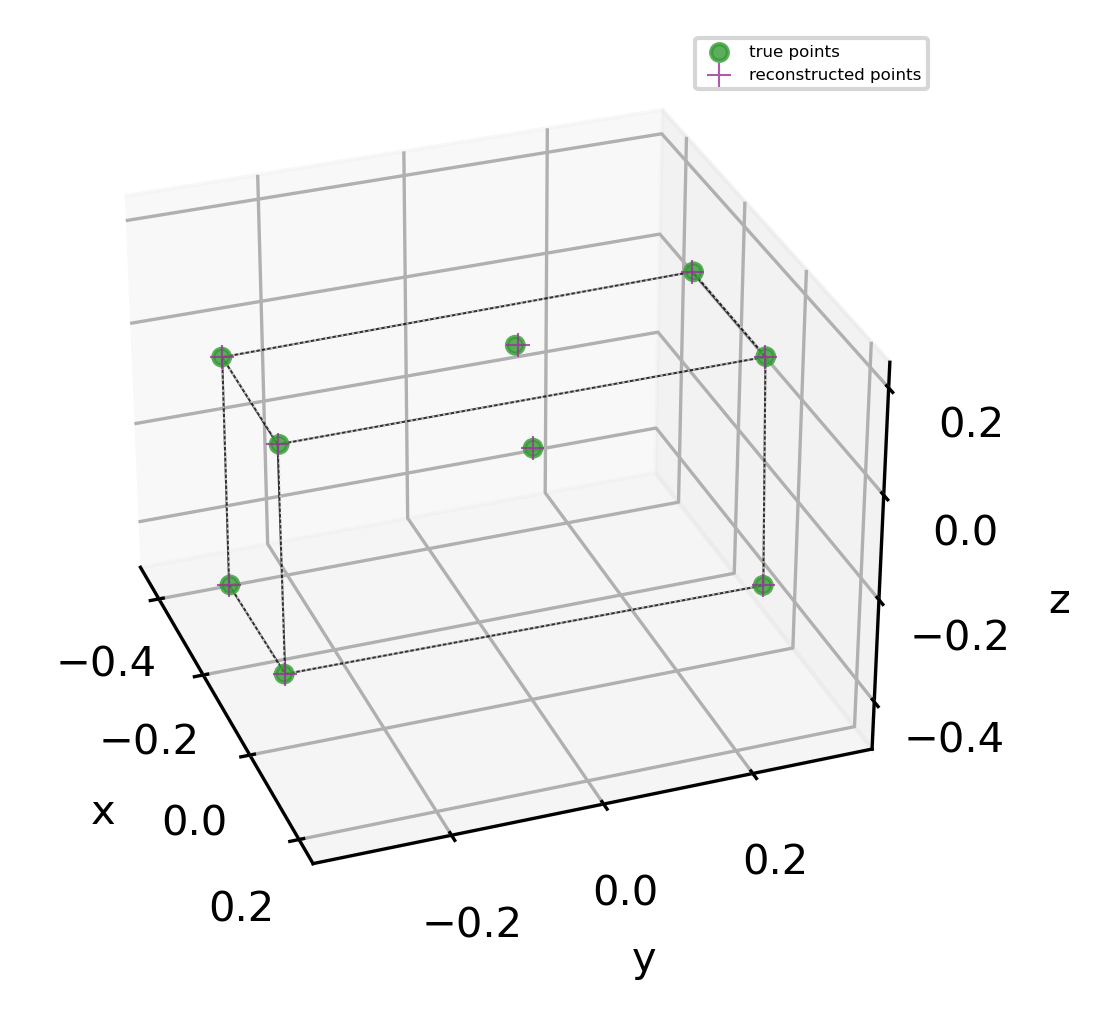

In [19]:
pts = data.loc[:, ['x', 'y', 'z']].values
fig = MPP.figure(dpi = 300)
ax = fig.add_subplot(1,1,1,projection='3d', aspect = 'auto')

edge_kwargs = dict( \
                  lw = 0.5 \
                , alpha = 0.8 \
                , zorder = 0 \
                , label = None \
                  )

for edge in [[0,1], [1,2], [2,3], [3,0], [4,5], [5,6], [4,1], [5,2], [6,3]]:
    ax.plot(  reco[edge, 0] \
            , reco[edge, 1] \
            , reco[edge, 2] \
            , color = 'k' \
            , ls = '-' \
            , **edge_kwargs
              )
    
    ax.plot(  pts[edge, 0] \
            , pts[edge, 1] \
            , pts[edge, 2] \
            , color = '0.9' \
            , ls = ':' \
            , **edge_kwargs
              )
    
    
ax.scatter(  pts[:, 0] \
           , pts[:, 1] \
           , pts[:, 2] \
           , s = 16 \
           , marker = 'o' \
           , color = (0.2, 0.6, 0.2) \
           , alpha = 0.8 \
           , zorder = 10 \
           , label = 'true points' \
          )

ax.scatter(  reco[:, 0] \
           , reco[:, 1] \
           , reco[:, 2] \
           , s = 32 \
           , marker = '+' \
           , linewidth = 0.5 \
           , color = (0.6, 0.2, 0.6) \
           , alpha = 0.8 \
           , zorder = 20 \
           , label = 'reconstructed points' \
          )



ax.legend(loc = 1, fontsize = 4)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(30, -20)

AxisEqual3D(ax)

MPP.show();

... and they do, **it is a box!**

It remains too be seen whether a space far from the calibration object can be well reconstructed. 

## Applied Example: Dog Video

When testing our setup, two kind shepards with their dogs passed by. 
(Our university is keeping sheep on the green areas of our campus.)

They allowed us to follow to the meadow and get a few shots of the animals. 

Here is one, in real time, from multiple perspectives:


<img src='images/dog1.gif'>



I tracked one stride cycle of the accelerating dog.

Because I have three cameras, I can reconstruct 3D data with two of them, and project that into the third camera (using a modified `dlt_inverse` from argus).

Purple are the tracked points, red are the reprojections (slowed down 10x):

<img src='images/dog3.gif'>

I will have to find out where the offset comes from; one reason might be that the calibration videos were not in sync. 

Apart from that, the data looks reasonable. *But...*

...let's look at the 3D data from all cameras:

<img src='images/dog2.gif'>

The lateral perspective seems okay. 
However, the depth is not well recovered. 
This is only in part due to the lacking contrast on some landmarks (e.g. the knee), as can be seen from the well-defined snout point. 
The other problem is the way I arranged my cameras (flat, next to each other).

I'll have to improve on that. 
One way is more accurate calibration. 
The other is optimization of the camera distance and angles. 
Noteworthy, the problem is general: if the view directions of cameras pointing at the same scene are at a low relative angle, i.e. if the focal planes are relatively parallel, then the depth is less accurate than the other spatial dimensions. 
**This inaccuracy is not captured by calculating the reprojection error**.


Still, getting accurate 3D data this way would be appealing:
units are in meters and 3D, so accurate angles and speeds can be determined. 
There is certainly room for improvement.


# OpenCV Attempts: Epipolar Geometry

The DLT reconstruction exemplified above is just scratching on the surface of stereo vision theory, or **epipolar geometry**.
There are a lot of resources that I found relevant for diving deeper:

- Lecture by Rich Radke https://www.youtube.com/watch?v=QzYn0OPO0Yw 
- Lecture by Cyrill Stachniss https://www.youtube.com/watch?v=cLeF-KNHgwU

- OpenCV documentation https://docs.opencv.org/master/d9/d0c/group__calib3d.html
- Argus documentation http://argus.web.unc.edu/formal-methods-and-definitions

This might help you to build a basic set of vocabulary, containing for example terms as 
- camera matrix $\leftarrow$ `CV.calibrateCamera`
- distortion coefficients $\leftarrow$ `CV.calibrateCamera`
- fundamental matrix $\leftarrow$ `CV.findFundamentalMat`
- essential matrix $\leftarrow$ `CV.findEssentialMat`
- epilines = epipolar lines $\leftarrow$ `CV.computeCorrespondEpilines`

The `openCV` functions next to it are some of many functions related to that topic. 

I experienced some trouble with `openCV` because my workflow deviates from the supposed calibration. 
The trouble arose because (i) my images were undistorted prior to processing, and (ii) I used a box instead of multiple views of a chessboard. 

But I also noted that the `openCV` error messages are not very instructive. For example, when trying to calibrate from a single scene, one might encounter the error 
`src\calibration.cpp:3110: error: (-210) objectPoints should contain vector of vectors of points of type Point3f in function cv::collectCalibrationData`.
In my case, this could be solved by adding a fake dimension to the `object_points` by wrapping it in a list `[object_points]`.
Another example are data types, which should always be `NP.float32` to avoid `openCV` chaos.

Nevertheless, `openCV` is probably the most comprehensive image processing library out there, and when you understand the logic behind it and are willing to scan through the raw code, it will doubtlessly be useful. 


## Epiline Calculation

Here is one example of how to use `openCV` to get **epilines** in corresponding images of different perspective. 
One can use the **fundamental matrix** to relate the images, without even knowing the absolute positions of the calibration object. 
When displayed during tracking, epilines can result in more accurate results on low-contrast landmarks.

The steps to get epilines are as follows:
- digitize points on calibration images of both cameras
- calculate the fundamental matrix with `CV.findFundamentalMat`
- compute "epilines" for arbitrary points of interest with `CV.computeCorrespondEpilines`



In [20]:
# get two arrays of calibration point coordinates
points = {cam: data.loc[:, [f'{coord}_{cam}' for coord in ['u', 'v'] ]].values \
          for cam in cams }

# calculate fundamental matrix
fundamental_matrix = {(cam1, cam2): CV.findFundamentalMat(points[cam1], points[cam2], CV.FM_LMEDS)[0] \
                      for cam1 in cams for cam2 in cams \
                     }

The epilines can be displayed on the images:

In [21]:
colors =[tuple(NP.random.randint(150,255,3).tolist()) for _ in range(points[1].shape[0])]

cross_images = { cam: images[cam].copy()//2 for cam in cams } # darkened images

# loop cameras
for cam in cams:
    pts = points[cam]
    img = cross_images[cam]
    
    if len(img.shape) == 3:
        r,c,ch = img.shape
        img = img // 2
    else:
        r,c = img.shape
        img = CV.cvtColor(img,CV.COLOR_GRAY2BGR) // 2
        
    # loop the other cameras
    for crosscam in cams:
        if cam == crosscam:
            continue
            
        funmat = fundamental_matrix[(cam, crosscam)]
        
        # add a line for each other image
        lines = CV.computeCorrespondEpilines(points[crosscam].reshape(-1,1,2), 2, funmat).reshape(-1,3)
        #print (lines)
        
        for count, r in enumerate(lines):
            x0,y0 = [0, -r[2]/r[1] ]
            x1,y1 = [c, -(r[2]+r[0]*c)/r[1] ]
        
            # superimpose line on the image
            img = CV.line(img, (int(x0),int(y0)), (int(x1),int(y1)), colors[count],1)
            
    # add a point for the current image

    for count, pt1 in enumerate(pts):
        img = CV.circle(img,tuple(NP.array(pt1, dtype = int)),5,colors[count],-1)
    
    cross_images[cam] = img

Here is the result:

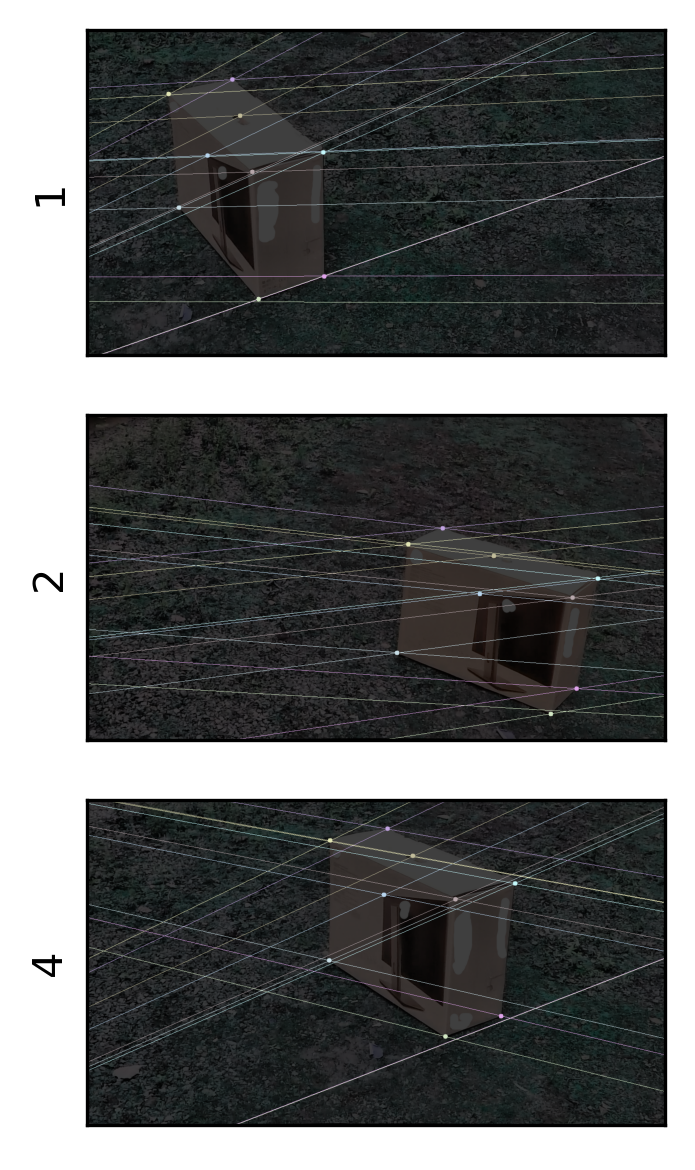

In [22]:
# drawing its lines on left image
fig = MPP.figure(dpi = 300)

for nr, cam in enumerate(cams):
    ax = fig.add_subplot(len(cams), 1, nr+1)
    ax.imshow(cross_images[cam], cmap = 'gray')
    
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel(cam)
    
MPP.tight_layout()
MPP.show()



Looking closely, one can see that some lines are off - again the calibration settings might not be ideal.

## OpenCV Camera Calibration

As mentioned above, `openCV` is versatile, but also bloated, which is the typical fate of complex code.

I ultimately failed to established my desired workflow in that toolbox due to trouble with `CV.calibrateCamera`.

I used it as follows: 

```
GetCMat = lambda foc, cx, cy: NP.array([[foc, 0, cx], [0, foc, cy], [0, 0, 1]], dtype = NP.float32)
GetDistorts = lambda k_vec: NP.array(k_vec, dtype = NP.float32)

CV.calibrateCamera(object_points \
                 , image_points \
                 , (1280, 720) # resolution \
                 , cameraMatrix = GetCMat(*start_values[:3]) \
                 , distCoeffs = GetDistorts(start_values[3:]) \
                 , flags = CV.CALIB_USE_INTRINSIC_GUESS \
                 )
```

The presence of `start_values` therein indicates that I used a manual layer of optimization (`scipy.optimize`) to get the correct camera matrix and distortion parameters. 
This is highly confusing to me: in my opinion, these parameters should be deterministic. 
However, in `openCV`, they depend on the start values I give, and how they depend could not even be reproducibly inferred with Nelder-Mead algorithm.


At that point, I researched more and turned to DLT as documented by Argus and Kwon. 


## Digression: Photogrammetry

Fundamental matrix extraction and epiline generation worked with a fundamental matrix that was calculated from known, manually digitized points.

In contrast, `openCV` also offers functions that find **keypoints** automatically, turns them into **descriptors**, and matches. Some code to give you a direction:

```
# Initiate ORB detector
orb = cv.ORB_create(32)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# brute force matching
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
matches = bf.match(des1, des2)

# Alternative: FLANN/K nearest neighbors (knn)
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)

# match:
matches = flann.knnMatch(np.float32(des1),np.float32(des2),k=2)


```

This is the heart of **Photogrammetry**, so feel free to create your own photogrammetry workflow with it.


# Summary

Above, I demonstrated how to calibrate an array of cameras in fixed relative position to get 3D data. 
Accuracy was limited with the simple calibration object I used.
Besides that, temporal sync and camera arrangement left room for improvement.

I also pointed out some directions for interested readers to instead use the much more potent `openCV` library, with all the pitfalls it contains.

I like the Argus slogan, *3D for the people*, and hope that I could contribute my part with this little tutorial. 
It turns out that it is not that trivial to capture our 3D world in 2D images. 
But thanks to web documentation and great open source projects, there is hope!

# References

- Jackson, Brandon E and Evangelista, Dennis J and Ray, Dylan D and Hedrick, Tyson L (2016). *3D for the people: multi-camera motion capture in the field with consumer-grade cameras and open source software.* Biology Open 5: 1334-1342; [https://doi.org/10.1242/bio.018713](https://doi.org/10.1242/bio.018713?target=_blank). [http://argus.web.unc.edu](http://argus.web.unc.edu?target=_blank), accessed 2020/08/01

- Kwon, Young-Hoo (2000). *Direct Linear Transformation (DLT).* Kwon3D Theoretical Foundation. [http://kwon3d.com/theories.html](http://kwon3d.com/theories.html?target=_blank), accessed 2020/08/01


Further reading:
- Abdel-Aziz, Y.I., & Karara, H.M. (1971). *Direct linear transformation from comparator coordinates into object space coordinates in close-range photogrammetry.* Proceedings of the Symposium on Close-Range Photogrammetry (pp. 1-18). Falls Church, VA: American Society of Photogrammetry.

- Miller, N.R., Shapiro, R., & McLaughlin, T.M. (1980). *A technique for obtaining spatial kinematic parameters of segments of biomechanical systems from cinematographic data.* J. Biomech 13, 535-547. 